In [1]:
from deepvo import *

timeouts set to 5


In [2]:
USE_CUDA=False

In [3]:
from torchviz import make_dot

## Can't take a batch, only one at a time... to be improved

In [4]:
def add_and_normalize(pose, diff):
#     print("pose: ", pose.shape)
#     print("diff: ", diff.shape)
    assert pose.shape == diff.shape
    new_pose = pose + diff
#     print("new_pose: ", new_pose)
    new_pose[:,3:] = new_pose[:,3:]/np.linalg.norm(new_pose[:, 3:], axis=1)
#     print("new_pose_norm: ", new_pose)
    return new_pose


def predict_trajectory(model, datapath, trajectory_length, validation_steps, preprocess):
    model.eval()
    model.training = False
    batch_size = len(datapath)

    kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

    for traj in datapath:
#         datapath1 = [get_image_list(traj, left_right="left")]
        datapath1 = [traj]
#         print(datapath1)
        data_loader = torch.utils.data.DataLoader(VisualOdometryDataLoaderTest(datapath1, 
                                                                        trajectory_length=trajectory_length, 
                                                                        transform=preprocess), 
                                               batch_size=1, 
                                               shuffle=False, 
                                               drop_last=True, 
                                               **kwargs)        
    
        true_len = 0
        to_start = np.asarray([0, 0, 0, 1, 0, 0, 0]).reshape(-1, 7)
#         to_start = np.asarray([8.228797e+00, 6.657083e+00, -1.301552e-01, -0.000000e+00, -0.000000e+00, 7.111126e-01, 7.030782e-01]).reshape(-1, 7)
        to_make_pred = []
        model.reset_hidden_states(size=batch_size, zero=True)
        for batch_idx, (images_stacked, odometries_stacked) in tqdm(enumerate(data_loader)):
            if batch_idx % trajectory_length and batch_idx != (len(data_loader) - 1):
#                 print("skips execution at batch_idx: ", batch_idx)
                gc.collect()
                continue
            if USE_CUDA:
                images_stacked, odometries_stacked = images_stacked.cuda(), odometries_stacked.cuda()
            if USE_TPU:
                images_stacked, odometries_stacked = images_stacked.to(device_tpu), odometries_stacked.to(device_tpu)
            images_stacked = images_stacked.permute(1, 0, 2, 3, 4)
            images_stacked, odometries_stacked = Variable(images_stacked), Variable(odometries_stacked)

            estimated_odometries = Variable(torch.zeros(odometries_stacked.shape))
            estimated_odometries = estimated_odometries.permute(1, 0, 2)
            if USE_CUDA:
                estimated_odometries = estimated_odometries.cuda()
            if USE_TPU:
                estimated_odometries = estimated_odometries.to(device_tpu)

            for t in range(trajectory_length):
                estimated_odometry = model(images_stacked[t])
                estimated_odometries[t] = estimated_odometry
                if batch_idx != (len(data_loader) - 1):
                    to_make_pred.append(estimated_odometry.cpu().detach().numpy())
            
            if batch_idx == (len(data_loader) - 1):
                remaining = len(data_loader) + trajectory_length - true_len - 1
                print(remaining)
                print(estimated_odometries.shape)
                for estimated_odometry in estimated_odometries[-remaining:]:
                    to_make_pred.append(estimated_odometry.cpu().detach().numpy())
                true_len+= remaining
            if batch_idx != (len(data_loader) - 1):        
                true_len += trajectory_length

        #         for t in range(trajectory_length):
        #             # compute output
        #             f, axarr = plt.subplots(1,2, figsize=(25,25))
        #             axarr[0].imshow(unnormalize(images_stacked[t][0][:3]).data.cpu().numpy().transpose((1, 2, 0)))
        #             axarr[1].imshow(unnormalize(images_stacked[t][0][3:]).data.cpu().numpy().transpose((1, 2, 0)))
        #             plt.show()


            if true_len >= validation_steps:
                print("breaks at batch_idx: ", batch_idx)
                break
        est_traj = [to_start]
        for diff in to_make_pred:
            est_traj.append(add_and_normalize(est_traj[-1], diff))
#         print(len(data_loader.dataset.poses[0]))
        return np.asarray(est_traj)#, data_loader.dataset.poses[len(datapath) -1 ][:len(est_traj)]

In [5]:
train_list, val_list, test_list = (['hospital/Hard/P040/',
  'carwelding/Hard/P001/',
  'soulcity/Hard/P002/',
  'abandonedfactory_night/Hard/P011/',
  'gascola/Easy/P003/',
  'endofworld/Easy/P008/',
  'hospital/Easy/P017/',
  'carwelding/Easy/P006/',
  'westerndesert/Easy/P010/',
  'westerndesert/Easy/P008/',
  'seasonsforest_winter/Easy/P005/',
  'seasonsforest_winter/Easy/P002/',
  'hospital/Hard/P042/',
  'oldtown/Easy/P002/',
  'office2/Hard/P010/',
  'westerndesert/Easy/P011/',
  'seasonsforest/Hard/P001/',
  'gascola/Hard/P001/',
  'amusement/Hard/P000/',
  'office2/Hard/P001/',
  'abandonedfactory/Hard/P009/',
  'gascola/Hard/P003/',
  'gascola/Hard/P008/',
  'abandonedfactory_night/Hard/P005/',
  'abandonedfactory_night/Easy/P009/',
  'westerndesert/Hard/P001/',
  'abandonedfactory_night/Hard/P003/',
  'neighborhood/Hard/P012/',
  'hospital/Easy/P000/',
  'amusement/Hard/P007/',
  'seasidetown/Easy/P005/',
  'hospital/Easy/P032/',
  'seasonsforest_winter/Easy/P001/',
  'office/Hard/P004/',
  'hospital/Easy/P023/',
  'neighborhood/Easy/P001/',
  'abandonedfactory_night/Hard/P006/',
  'endofworld/Easy/P000/',
  'office2/Hard/P009/',
  'hospital/Easy/P007/',
  'westerndesert/Easy/P007/',
  'abandonedfactory_night/Easy/P006/',
  'gascola/Easy/P007/',
  'westerndesert/Easy/P005/',
  'seasonsforest_winter/Easy/P007/',
  'abandonedfactory_night/Hard/P010/',
  'hospital/Easy/P009/',
  'hospital/Easy/P012/',
  'ocean/Easy/P009/',
  'abandonedfactory/Easy/P000/',
  'seasonsforest_winter/Easy/P008/',
  'office/Easy/P002/',
  'soulcity/Hard/P001/',
  'westerndesert/Hard/P006/',
  'seasonsforest_winter/Easy/P003/',
  'abandonedfactory/Hard/P010/',
  'westerndesert/Easy/P006/',
  'abandonedfactory/Easy/P011/',
  'hospital/Hard/P046/',
  'ocean/Hard/P006/',
  'hospital/Easy/P026/',
  'hospital/Hard/P037/',
  'soulcity/Hard/P000/',
  'neighborhood/Hard/P003/',
  'neighborhood/Easy/P021/',
  'hospital/Easy/P003/',
  'carwelding/Easy/P007/',
  'office/Hard/P005/',
  'ocean/Hard/P009/',
  'office/Easy/P004/',
  'office2/Hard/P003/',
  'seasidetown/Easy/P001/',
  'ocean/Hard/P008/',
  'office2/Easy/P007/',
  'abandonedfactory_night/Easy/P008/',
  'japanesealley/Easy/P002/',
  'neighborhood/Easy/P002/',
  'amusement/Hard/P006/',
  'japanesealley/Easy/P004/',
  'neighborhood/Easy/P004/',
  'office2/Easy/P011/',
  'abandonedfactory_night/Easy/P002/',
  'neighborhood/Hard/P006/',
  'hospital/Easy/P015/',
  'abandonedfactory_night/Hard/P002/',
  'seasonsforest_winter/Hard/P015/',
  'seasonsforest/Hard/P002/',
  'westerndesert/Easy/P009/',
  'neighborhood/Hard/P016/',
  'seasidetown/Easy/P002/',
  'carwelding/Easy/P002/',
  'abandonedfactory_night/Easy/P011/',
  'office/Hard/P003/',
  'soulcity/Easy/P008/',
  'gascola/Hard/P000/',
  'neighborhood/Hard/P015/',
  'hospital/Easy/P014/',
  'abandonedfactory/Hard/P011/',
  'neighborhood/Hard/P013/',
  'ocean/Easy/P006/',
  'hospital/Hard/P047/',
  'japanesealley/Easy/P007/',
  'oldtown/Hard/P004/',
  'neighborhood/Easy/P013/',
  'ocean/Hard/P005/',
  'seasonsforest/Easy/P010/',
  'soulcity/Easy/P006/',
  'abandonedfactory/Easy/P002/',
  'seasonsforest_winter/Hard/P011/',
  'office/Easy/P000/',
  'soulcity/Easy/P010/',
  'office/Hard/P002/',
  'hospital/Easy/P004/',
  'hospital/Easy/P035/',
  'neighborhood/Hard/P004/',
  'japanesealley/Easy/P003/',
  'soulcity/Easy/P005/',
  'soulcity/Hard/P009/',
  'soulcity/Easy/P007/',
  'abandonedfactory/Hard/P005/',
  'hospital/Easy/P005/',
  'abandonedfactory_night/Easy/P003/',
  'seasonsforest_winter/Hard/P014/',
  'abandonedfactory_night/Easy/P004/',
  'hospital/Hard/P048/',
  'carwelding/Easy/P005/',
  'neighborhood/Easy/P007/',
  'ocean/Easy/P000/',
  'hospital/Easy/P019/',
  'hospital/Easy/P031/',
  'office2/Hard/P002/',
  'abandonedfactory/Hard/P000/',
  'hospital/Easy/P028/',
  'seasonsforest/Easy/P009/',
  'soulcity/Easy/P011/',
  'oldtown/Hard/P007/',
  'seasonsforest_winter/Easy/P004/',
  'seasonsforest/Hard/P004/',
  'ocean/Hard/P000/',
  'seasonsforest_winter/Hard/P012/',
  'office/Easy/P001/',
  'seasonsforest_winter/Hard/P013/',
  'hospital/Easy/P030/',
  'ocean/Easy/P001/',
  'japanesealley/Hard/P004/',
  'office/Easy/P003/',
  'abandonedfactory/Easy/P006/',
  'hospital/Easy/P036/',
  'neighborhood/Hard/P001/',
  'ocean/Hard/P007/',
  'abandonedfactory/Hard/P006/',
  'ocean/Easy/P005/',
  'oldtown/Hard/P006/',
  'westerndesert/Easy/P001/',
  'japanesealley/Hard/P005/',
  'carwelding/Hard/P003/',
  'abandonedfactory_night/Hard/P009/',
  'endofworld/Easy/P009/',
  'neighborhood/Easy/P017/',
  'amusement/Easy/P002/',
  'seasidetown/Hard/P003/',
  'abandonedfactory_night/Easy/P007/',
  'soulcity/Hard/P003/',
  'abandonedfactory_night/Easy/P012/',
  'neighborhood/Easy/P020/',
  'endofworld/Hard/P002/',
  'gascola/Hard/P009/',
  'ocean/Easy/P013/',
  'endofworld/Hard/P000/',
  'amusement/Easy/P003/',
  'seasonsforest_winter/Easy/P000/',
  'carwelding/Easy/P001/',
  'abandonedfactory_night/Hard/P007/',
  'abandonedfactory/Easy/P010/',
  'hospital/Easy/P025/',
  'abandonedfactory/Easy/P009/',
  'westerndesert/Easy/P012/',
  'office/Easy/P005/',
  'seasonsforest/Hard/P006/',
  'oldtown/Easy/P001/',
  'soulcity/Easy/P003/',
  'office2/Easy/P009/',
  'gascola/Easy/P001/',
  'oldtown/Easy/P000/',
  'hospital/Hard/P044/',
  'hospital/Easy/P008/',
  'abandonedfactory/Easy/P004/',
  'hospital/Easy/P027/',
  'hospital/Easy/P024/',
  'endofworld/Easy/P003/',
  'neighborhood/Easy/P009/',
  'hospital/Easy/P013/',
  'seasidetown/Hard/P002/',
  'gascola/Easy/P006/',
  'neighborhood/Hard/P007/',
  'hospital/Hard/P045/',
  'seasidetown/Easy/P004/',
  'seasidetown/Hard/P001/',
  'hospital/Easy/P029/',
  'endofworld/Easy/P002/',
  'office2/Hard/P006/',
  'japanesealley/Easy/P001/',
  'abandonedfactory_night/Hard/P012/',
  'hospital/Hard/P043/',
  'japanesealley/Hard/P001/',
  'office2/Easy/P003/',
  'office2/Hard/P008/',
  'carwelding/Hard/P000/',
  'carwelding/Easy/P004/',
  'oldtown/Easy/P007/',
  'endofworld/Hard/P005/',
  'office2/Hard/P005/',
  'office2/Easy/P005/',
  'soulcity/Easy/P000/',
  'gascola/Hard/P004/',
  'neighborhood/Hard/P008/',
  'abandonedfactory/Easy/P008/',
  'ocean/Easy/P012/',
  'soulcity/Easy/P004/',
  'seasidetown/Easy/P006/',
  'westerndesert/Easy/P013/',
  'abandonedfactory_night/Easy/P010/',
  'hospital/Easy/P033/',
  'neighborhood/Hard/P000/',
  'ocean/Hard/P003/',
  'amusement/Hard/P003/',
  'abandonedfactory_night/Hard/P008/',
  'carwelding/Hard/P002/',
  'neighborhood/Easy/P005/',
  'seasonsforest_winter/Easy/P009/',
  'endofworld/Easy/P001/',
  'seasonsforest_winter/Easy/P006/',
  'oldtown/Easy/P005/',
  'abandonedfactory/Hard/P003/',
  'oldtown/Hard/P005/',
  'seasonsforest/Easy/P007/',
  'oldtown/Hard/P001/',
  'abandonedfactory_night/Hard/P000/',
  'ocean/Easy/P011/',
  'neighborhood/Hard/P009/',
  'neighborhood/Easy/P018/',
  'seasidetown/Easy/P000/',
  'neighborhood/Hard/P017/',
  'abandonedfactory_night/Easy/P013/',
  'soulcity/Easy/P002/',
  'hospital/Easy/P006/',
  'westerndesert/Hard/P002/',
  'abandonedfactory_night/Hard/P001/',
  'ocean/Easy/P010/',
  'office2/Easy/P008/',
  'endofworld/Hard/P001/',
  'office/Hard/P007/',
  'office/Easy/P006/',
  'hospital/Hard/P041/',
  'neighborhood/Easy/P015/',
  'hospital/Easy/P010/',
  'abandonedfactory/Hard/P007/',
  'oldtown/Hard/P008/',
  'endofworld/Easy/P006/',
  'amusement/Easy/P004/',
  'seasonsforest_winter/Hard/P017/',
  'ocean/Hard/P001/',
  'westerndesert/Hard/P000/',
  'neighborhood/Easy/P016/',
  'ocean/Easy/P008/',
  'hospital/Easy/P034/',
  'soulcity/Easy/P001/',
  'seasidetown/Hard/P000/',
  'office/Hard/P001/',
  'office/Hard/P006/',
  'japanesealley/Easy/P005/',
  'office2/Hard/P007/',
  'abandonedfactory_night/Hard/P013/',
  'hospital/Easy/P021/',
  'oldtown/Hard/P002/',
  'soulcity/Easy/P009/',
  'amusement/Hard/P005/',
  'gascola/Hard/P005/',
  'neighborhood/Hard/P002/',
  'neighborhood/Hard/P011/',
  'neighborhood/Hard/P010/',
  'neighborhood/Easy/P008/',
  'gascola/Easy/P004/',
  'office2/Easy/P006/',
  'oldtown/Hard/P000/',
  'office2/Easy/P004/',
  'seasonsforest_winter/Hard/P016/',
  'seasidetown/Easy/P003/',
  'soulcity/Hard/P008/',
  'hospital/Hard/P038/',
  'seasonsforest/Easy/P008/',
  'endofworld/Easy/P007/',
  'westerndesert/Hard/P004/',
  'westerndesert/Hard/P003/',
  'seasidetown/Easy/P009/',
  'gascola/Hard/P007/',
  'hospital/Easy/P022/',
  'ocean/Easy/P004/',
  'westerndesert/Hard/P005/',
  'abandonedfactory_night/Hard/P014/',
  'ocean/Hard/P004/',
  'oldtown/Easy/P004/',
  'ocean/Hard/P002/',
  'amusement/Easy/P001/',
  'seasonsforest/Hard/P005/',
  'endofworld/Easy/P005/',
  'seasidetown/Easy/P008/',
  'neighborhood/Hard/P014/',
  'hospital/Easy/P011/',
  'neighborhood/Easy/P014/',
  'abandonedfactory/Hard/P008/',
  'japanesealley/Hard/P000/',
  'soulcity/Easy/P012/',
  'endofworld/Easy/P004/',
  'abandonedfactory/Hard/P004/',
  'seasidetown/Hard/P004/',
  'abandonedfactory/Easy/P005/',
  'hospital/Hard/P049/',
  'westerndesert/Hard/P007/',
  'neighborhood/Easy/P003/',
  'seasonsforest/Easy/P001/',
  'amusement/Easy/P006/',
  'neighborhood/Easy/P019/',
  'neighborhood/Easy/P012/',
  'soulcity/Hard/P004/',
  'ocean/Easy/P002/',
  'neighborhood/Easy/P000/',
  'neighborhood/Easy/P010/',
  'amusement/Hard/P001/',
  'seasidetown/Easy/P007/',
  'hospital/Easy/P002/',
  'amusement/Easy/P008/',
  'abandonedfactory/Hard/P001/',
  'japanesealley/Hard/P002/',
  'seasonsforest/Easy/P002/',
  'seasonsforest/Easy/P004/',
  'seasonsforest/Easy/P011/',
  'hospital/Easy/P016/',
  'office2/Easy/P010/',
  'seasonsforest_winter/Hard/P010/',
  'westerndesert/Easy/P002/',
  'amusement/Easy/P007/',
  'gascola/Hard/P006/',
  'abandonedfactory_night/Easy/P005/',
  'westerndesert/Easy/P004/',
  'office2/Easy/P000/',
  'gascola/Hard/P002/',
  'abandonedfactory_night/Easy/P001/',
  'amusement/Hard/P004/'],
 ['office2/Hard/P004/',
  'hospital/Hard/P039/',
  'endofworld/Hard/P006/',
  'hospital/Easy/P018/',
  'oldtown/Hard/P003/',
  'abandonedfactory/Easy/P001/',
  'abandonedfactory/Hard/P002/',
  'seasonsforest/Easy/P003/',
  'office2/Hard/P000/',
  'gascola/Easy/P008/'],
 ['japanesealley/Hard/P003/',
  'seasonsforest/Easy/P005/',
  'seasonsforest_winter/Hard/P018/',
  'amusement/Hard/P002/',
  'office/Hard/P000/',
  'gascola/Easy/P005/',
  'hospital/Easy/P001/',
  'hospital/Easy/P020/',
  'soulcity/Hard/P005/',
  'neighborhood/Hard/P005/'])

In [6]:
 class fake_arg_parser(argparse.ArgumentParser):
    def __init__(self,checkpoint_path, datapath, 
                 mode='train', checkpoint=None,
                 bsize=16, trajectory_length=32, 
                 lr=0.0001, momentum=0.5, 
                 weight_decay=1e-4, tau=0.001, 
                 train_iter=1, validation_steps=100,
                 epsilon=50000):
        self.mode = mode
        self.datapath = datapath
        self.bsize = bsize
        self.checkpoint_path =checkpoint_path
        self.checkpoint = checkpoint
        self.lr = lr
        self.momentum = momentum
        self.weight_decay =weight_decay
        self.tau =tau
        self.train_iter = train_iter
        self.validation_steps = validation_steps
        self.epsilon = epsilon
        self.trajectory_length = trajectory_length

In [7]:
args = fake_arg_parser("checkpoints_v2", None, checkpoint="checkpoints_v2/checkpoint_1_abandonedfactory_night.Easy.P005..office2.Hard.P002..pth"  )

In [8]:
if USE_TPU:
    import torch_xla
    import torch_xla.core.xla_model as xm
    device_tpu = xm.xla_device()
model = DeepVONet()

120 160
60 80
30 40
15 20
8 10
4 5


In [9]:
if args.checkpoint is not None:
    print("loading")
    checkpoint = torch.load(args.checkpoint, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['state_dict'])
if USE_CUDA:
    model.cuda()
if USE_TPU:
    model = model.to(device_tpu)


loading


In [13]:
model

DeepVONet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Dropout2d(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Dropout2d(p=0.2, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Dropout2d(p=0.2, inplace=False)
  )
  (conv3_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): LeakyReLU(negative_slope=0.1, inplac

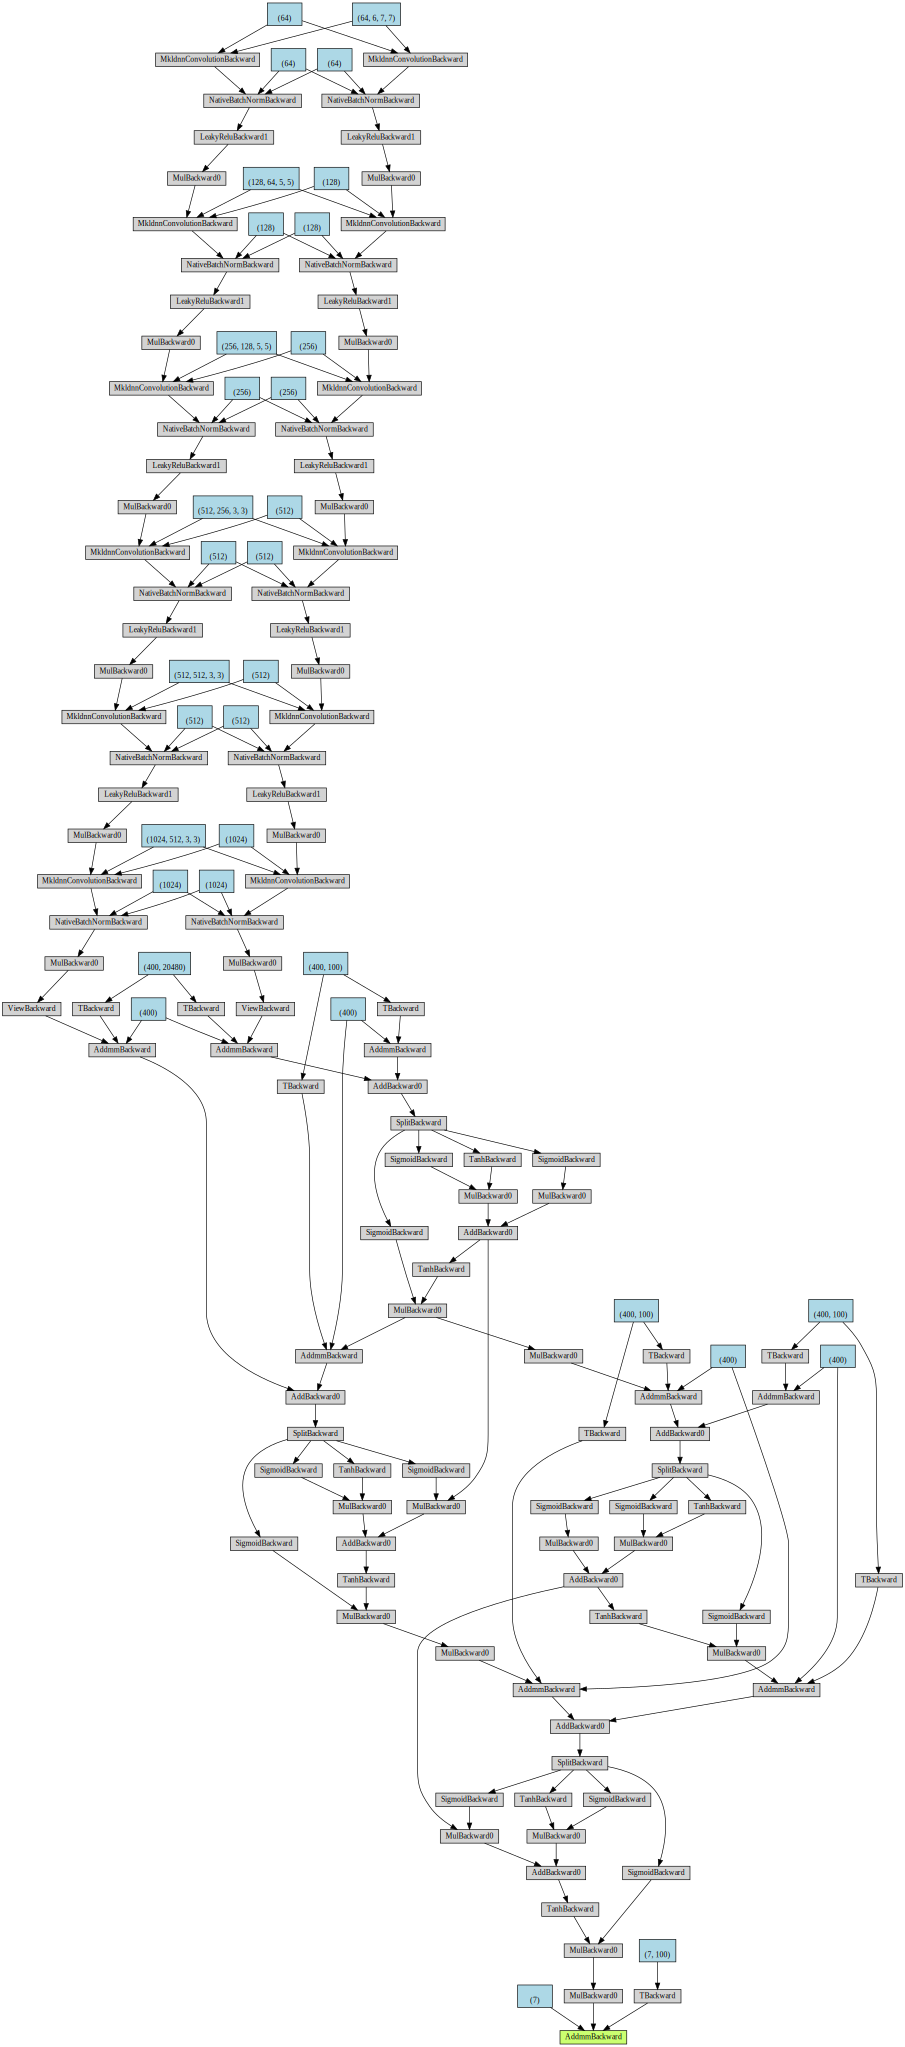

In [12]:
x = torch.zeros(1, 6, 240, 320, dtype=torch.float, requires_grad=False)
out = model(x)
make_dot(out)

In [14]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

normalize = transforms.Normalize(
    #mean=[121.50361069 / 127., 122.37611083 / 127., 121.25987563 / 127.],
    mean=[127. / 255., 127. / 255., 127. / 255.],
    std=[1 / 255., 1 / 255., 1 / 255.]
#     mean=[0., 0., 0.],
#     std=[1, 1, 1]
    
)

preprocess = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    normalize
])
unnormalize = UnNormalize(mean=(127. / 255., 127. / 255., 127. / 255.),
    std=(1 / 255., 1 / 255., 1 / 255.))

In [12]:
# download_image_directory(get_image_list(val_list[0]))

In [13]:
ans = predict_trajectory(model, [val_list[0]], 32, 345, preprocess)

0it [00:00, ?it/s]

[345] 345 313


3it [00:51, 24.32s/it]

trying again


58it [02:31,  1.48s/it]

trying again


138it [05:14,  1.86s/it]Unable to stream download: generator raised StopIteration


trying again


313it [11:27,  2.20s/it]

24
torch.Size([32, 1, 7])


345


In [14]:
ans[0].shape


(345, 1, 7)

In [21]:
fe = open("pose_est.txt", "w")
fr = open("pose_gt.txt", "w")
for est, real in zip(ans[0], ans[1]):
    fe.write(" ".join(["{:e}".format(x) for x in est[0]]))
    fe.write("\n")
    fr.write(" ".join(["{:e}".format(x) for x in real]))
    fr.write("\n")
        
fe.close()
fr.close()

In [22]:
!python evaluation/tartanair_evaluator.py

  Scale, 0.7360846383875489
  ATE scale: 1.617140622172488
{'ate_score': 4.414702165371033, 'rpe_score': (0.5597070133778512, 12.385804122225819), 'kitti_score': (2.328203432600562, 0.7657783703381803)}


In [16]:
!python evaluation/tartanair_evaluator.py

  Scale, 1.1717595229061601
  ATE scale: 2.0525641961996857
{'ate_score': 4.943710191814142, 'rpe_score': (1.2337051938315682, 11.488603746507955), 'kitti_score': (4.540994530680308, 0.7491602367241257)}


In [17]:
output_folder = "submission_1"

In [32]:
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
else:
    print("folder exists wtf is wrong with you?")

for folder in sorted(os.listdir("mono")):
    if "M" in folder and folder != "ME000":
        curr_path = os.path.join("mono", folder)
        image_list=[os.path.join(curr_path, image_name) for image_name in sorted(os.listdir(curr_path))]
#         print(image_list)
#         checkpoint = torch.load(args.checkpoint_path+"/"+item, map_location=torch.device('cpu'))
#         model.load_state_dict(checkpoint['state_dict'])
        ans = predict_trajectory(model, [image_list], 32, 100000, preprocess)

        fe = open(os.path.join(output_folder, folder +".txt"), "w")
#         fr = open("pose_estimations/pose_real.txt", "w")
        for i, est in enumerate(ans):
            fe.write(" ".join(["{:e}".format(x) for x in est[0]]))
            if i != len(ans) - 1:
                fe.write("\n")
#             fr.write(" ".join(["{:e}".format(x) for x in real]))
#             fr.write("\n")

        fe.close()
#         fr.close()
#         !python evaluation/tartanair_evaluator.py

folder exists wtf is wrong with you?
[1083] 1083 1051


1051it [08:12,  2.13it/s]

26
torch.Size([32, 1, 7])


folder exists wtf is wrong with you?
[1294] 1294 1262


1262it [08:24,  2.50it/s]

13
torch.Size([32, 1, 7])


folder exists wtf is wrong with you?
[1487] 1487 1455


1455it [09:30,  2.55it/s]

14
torch.Size([32, 1, 7])


folder exists wtf is wrong with you?
[1200] 1200 1168


1168it [07:21,  2.64it/s]

15
torch.Size([32, 1, 7])


folder exists wtf is wrong with you?
[1879] 1879 1847


1847it [11:26,  2.69it/s]

22
torch.Size([32, 1, 7])


folder exists wtf is wrong with you?
[1014] 1014 982


982it [06:05,  2.69it/s]

21
torch.Size([32, 1, 7])


folder exists wtf is wrong with you?
[910] 910 878


878it [05:47,  2.53it/s]

13
torch.Size([32, 1, 7])


folder exists wtf is wrong with you?
[2332] 2332 2300


2300it [14:12,  2.70it/s]

27
torch.Size([32, 1, 7])


folder exists wtf is wrong with you?
[357] 357 325


325it [01:57,  2.76it/s]

4
torch.Size([32, 1, 7])
folder exists wtf is wrong with you?
[698] 698 666



666it [04:06,  2.71it/s]

25
torch.Size([32, 1, 7])


folder exists wtf is wrong with you?
[402] 402 370


370it [02:21,  2.61it/s]

17
torch.Size([32, 1, 7])
folder exists wtf is wrong with you?
[662] 662 630



630it [03:51,  2.72it/s]

21
torch.Size([32, 1, 7])


folder exists wtf is wrong with you?
[926] 926 894


894it [05:44,  2.59it/s]

29
torch.Size([32, 1, 7])


folder exists wtf is wrong with you?
[845] 845 813


813it [05:08,  2.63it/s]

12
torch.Size([32, 1, 7])


folder exists wtf is wrong with you?
[938] 938 906


906it [05:30,  2.74it/s]

9
torch.Size([32, 1, 7])


In [29]:
fe = open(os.path.join(output_folder, folder +".txt"), "w")


In [27]:
len(ans)

1742

In [30]:
for i, est in enumerate(ans):
#     print(est)
    fe.write(" ".join(["{:e}".format(x) for x in est[0]]))
    if i != len(ans) - 1:
#         print("newline")
        fe.write("\n")
fe.close()


[[0. 0. 0. 1. 0. 0. 0.]]
[[ 2.39444477e-03 -1.90021619e-02  3.91441165e-03  9.99998008e-01
   2.49374207e-04 -1.85942814e-03  6.80696329e-04]]
[[ 1.61294932e-02 -4.96594496e-02  1.09116556e-02  9.99982342e-01
   5.66403982e-04 -5.67305926e-03  1.67691177e-03]]
[[ 3.84899187e-02 -8.54767002e-02  1.91346304e-02  9.99946723e-01
   8.75244279e-04 -9.85943546e-03  2.92849502e-03]]
[[ 0.06609291 -0.12099462  0.02793977  0.99989286  0.00120204 -0.01391224
   0.00438953]]
[[ 0.09701855 -0.15469693  0.03698834  0.99982148  0.00153938 -0.01785611
   0.00598377]]
[[ 0.12946636 -0.18533184  0.04611497  0.99973146  0.00187928 -0.02179173
   0.00765459]]
[[ 0.15920986 -0.21180616  0.05499269  0.99961623  0.0021986  -0.02599344
   0.0093218 ]]
[[ 0.17920055 -0.22873775  0.06328419  0.99947693  0.00245912 -0.03033709
   0.0109303 ]]
[[ 0.18654774 -0.23691779  0.07095851  0.9993213   0.00262033 -0.03456425
   0.01246519]]
[[ 0.18238212 -0.24173608  0.07825119  0.99915542  0.00267461 -0.03856522
   0.01

   2.57104544e-01 -9.15458360e-01  3.09557139e-01]]
[[-2.34848966e+01 -3.90003599e+01  3.49843458e+00  1.93550022e-03
   2.55796333e-01 -9.15783451e-01  3.09685583e-01]]
[[-2.34658971e+01 -3.91550280e+01  3.50702847e+00  9.18445665e-04
   2.54377596e-01 -9.16127022e-01  3.09842661e-01]]
[[-2.34568789e+01 -3.93099851e+01  3.51527785e+00 -1.28481560e-04
   2.52841123e-01 -9.16500574e-01  3.09996852e-01]]
[[-2.34510491e+01 -3.94659960e+01  3.52345139e+00 -1.13827710e-03
   2.51213107e-01 -9.16892036e-01  3.10160722e-01]]
[[-2.34458175e+01 -3.96193055e+01  3.53143628e+00 -2.03730519e-03
   2.49500560e-01 -9.17297702e-01  3.10338920e-01]]
[[-2.34395178e+01 -3.97691395e+01  3.53929390e+00 -2.80330815e-03
   2.47724812e-01 -9.17709421e-01  3.10538205e-01]]
[[-2.34317358e+01 -3.99147149e+01  3.54702977e+00 -3.43782283e-03
   2.45918447e-01 -9.18113778e-01  3.10772246e-01]]
[[-2.34222992e+01 -4.00558577e+01  3.55466003e+00 -3.94790847e-03
   2.44096275e-01 -9.18505976e-01  3.11043719e-01]]
[[-2

   1.30585332e-02 -7.85589742e-01  3.67440629e-01]]
[[-3.03205845e+01 -4.90789078e+01  8.80033197e+00 -4.96741512e-01
   1.24462309e-02 -7.86331314e-01  3.67118546e-01]]
[[-3.04203365e+01 -4.90907558e+01  8.81133290e+00 -4.96028267e-01
   1.18036757e-02 -7.86903566e-01  3.66877923e-01]]
[[-3.05244671e+01 -4.91096517e+01  8.82283439e+00 -4.95644183e-01
   1.10974796e-02 -7.87237782e-01  3.66702010e-01]]
[[-3.06215034e+01 -4.91457042e+01  8.83587485e+00 -4.95807094e-01
   1.03999902e-02 -7.87190669e-01  3.66603350e-01]]
[[-3.06935742e+01 -4.91944257e+01  8.85069794e+00 -4.96330204e-01
   9.81473618e-03 -7.86908091e-01  3.66518287e-01]]
[[-3.07495113e+01 -4.92428295e+01  8.86599155e+00 -4.96825069e-01
   9.47897619e-03 -7.86638641e-01  3.66435052e-01]]
[[-3.07954191e+01 -4.92849726e+01  8.88121007e+00 -4.97316955e-01
   9.38711329e-03 -7.86319210e-01  3.66455766e-01]]
[[-3.08270836e+01 -4.93353298e+01  8.89622734e+00 -4.98117160e-01
   9.64186721e-03 -7.85825213e-01  3.66421976e-01]]
[[-3

In [29]:
# %%time
# tl_copy = list(train_list)
# for i, direc in enumerate(train_list):
#     train_list[i] = (direc, len(read_text_file(get_posefile(direc)).split("\n")) - 1)

In [ ]:
# train_list.sort(key= lambda x: x[1])

In [ ]:
# train_list = [x[0] for x in train_list]

In [ ]:
# train_list